In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, GridSearchCV
from IPython.display import Image
import pydotplus


In [2]:
url = "https://raw.githubusercontent.com/BigDataGal/Python-for-Data-Science/master/titanic-train.csv"
data = pd.read_csv(url)

#### Problem Statement:
Use only Pclass, Sex, Age, SibSp (Siblings aboard), Parch
(Parents/children aboard), and Fare to predict whether a passenger
survived.


## Exploratory data analysis
1. Explore data
2. Check for missing data
3. Describe features
4. Handle missing values

### 2.1 Explore data and features

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
data.shape

(891, 12)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Age, Cabin and Embarked - these attributes have missing values

As per the problem statement, we should use only Pclass, Sex, Age, SibSp, Parch and Fare to predict whether passengers survived.
So I will create a new dataframe with only these attributes in the data. We will drop the other attributes like PassengerId, Name, Cabin and Embarked.

In [5]:
# Drop features that are unnecessary
df = data.drop(['PassengerId','Name','Ticket','Cabin','Embarked'], axis=1)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500


In [6]:
df.isnull().sum() # Check for null values to be imputed.

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
dtype: int64

In [7]:
print("Percentage of null-values in Age %.2f%%" %(df['Age'].isnull().sum()/df.shape[0]*100))

Percentage of null-values in Age 19.87%


We will handle these in the Feature Engineering part

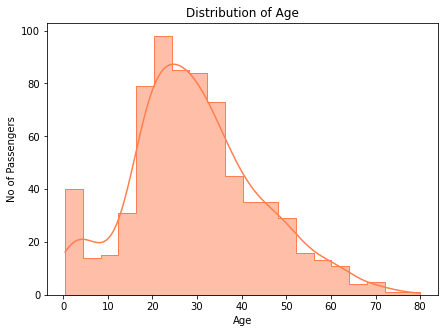

In [9]:
plt.figure(figsize=(7,5))
sns.histplot(data=df['Age'], bins=20, kde=True, color='coral', element='step')
plt.title("Distribution of Age")
plt.ylabel('No of Passengers')
plt.show()

We can clearly see that 'Age' is left-skewed.

Let's check for outliers

<AxesSubplot:xlabel='Age'>

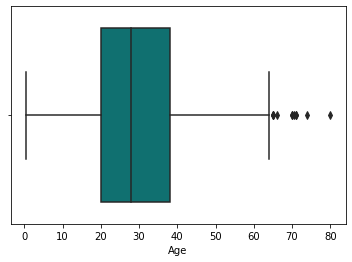

In [8]:
sns.boxplot(x=df['Age'], color='teal')

We can clearly see some outliers in the data. We have to handle these outliers

In [9]:
print("The mean Age of passengers:", df['Age'].mean())
print("The median Age of passengers:",df['Age'].median())

The mean Age of passengers: 29.69911764705882
The median Age of passengers: 28.0


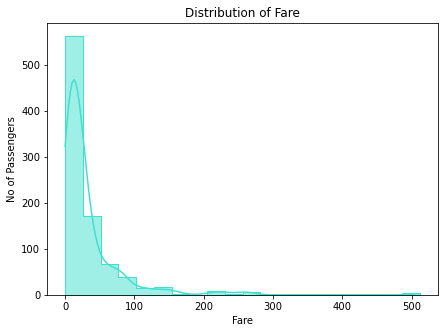

In [12]:
plt.figure(figsize=(7,5))
sns.histplot(data=df['Fare'], bins=20, kde=True, color='turquoise', element='step')
plt.title("Distribution of Fare")
plt.ylabel('No of Passengers')
plt.show()

Here we can see that Fare is left-skewed. This could be because of the there were more passengers in Class 3 than 1 and 2

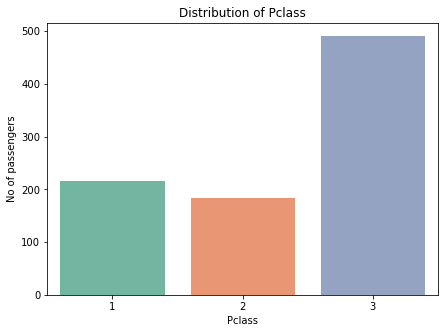

In [13]:
#Visualize the distribution of Pclass
plt.figure(figsize=(7,5))
sns.countplot(x='Pclass',data=df, palette='Set2')
plt.title('Distribution of Pclass')
plt.ylabel('No of passengers')
plt.show()

Here we can clearly see that more passengers travelled in PClass 3 and that's the reason wby fare is skewed

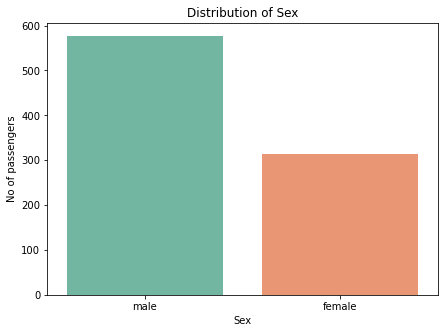

In [14]:
#Visualize the distribution of Sex
plt.figure(figsize=(7,5))
sns.countplot(x='Sex',data=df, palette='Set2')
plt.title('Distribution of Sex')
plt.ylabel('No of passengers')
plt.show()

Clearly there were more male passengers than females

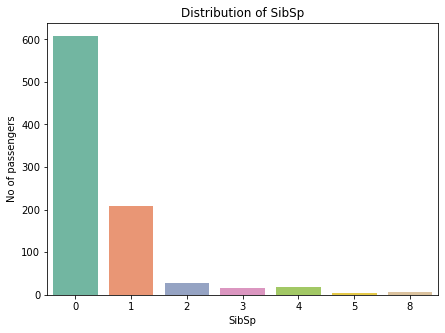

In [15]:
#Visualize the distribution of Sex
plt.figure(figsize=(7,5))
sns.countplot(x='SibSp',data=df, palette='Set2')
plt.title('Distribution of SibSp')
plt.ylabel('No of passengers')
plt.show()

### Handle missing values

'Age' contains missing values and it needs to be imputed (Mean / Median)

Since Age is left-skewed I'll impute with median Age for all missing values

In [10]:
df['Age'] = np.where(df['Age'].isnull(),df['Age'].median(),df['Age'])

In [11]:
df['Age'].isnull().sum()

0

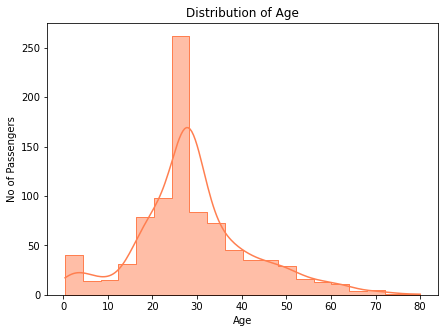

In [12]:
plt.figure(figsize=(7,5))
sns.histplot(data=df['Age'], bins=20, kde=True, color='coral', element='step')
plt.title("Distribution of Age")
plt.ylabel('No of Passengers')
plt.show()

After imputation, the data is almost normally distributed

As per the problem, I have to solve this problem only using Decision Tree.

I am not removing outliers from the dataset as Decision Tree is robust to outliers in the data

### Encoding for Sex feature

In [20]:
pd.get_dummies(df['Sex'])

,0,1
0,1,0
1,0,1
2,0,1
3,0,1
4,1,0
...,...,...
886,1,0
887,0,1
888,0,1
889,1,0


In [21]:
df['Sex']=pd.get_dummies(df['Sex'], drop_first=True)

In our encoding, Sex = 1 --> Female and Sex=0 --> Male

In [22]:
df['Sex'].nunique()

2

In [32]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,0,22.0,1,0,7.2500
1,1,1,1,38.0,1,0,71.2833
2,1,3,1,26.0,0,0,7.9250
3,1,1,1,35.0,1,0,53.1000
4,0,3,0,35.0,0,0,8.0500


## Decision Tree building

### Prepare data

In [33]:
X = df.drop(['Survived'],axis=1)
y = df['Survived']

In [34]:
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=100)

In [37]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare
0,3,0,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,3,1,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,3,0,35.0,0,0,8.0500


### Model building on train data

In [38]:
clf = DecisionTreeClassifier()
clf.fit(x_train,y_train)

DecisionTreeClassifier()

In [39]:
feature_name = list(X.columns)
class_name = list(y_train.unique())
print("Feature names are:", feature_name)
print("Survived categories:",class_name)

Feature names are: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
Survived categories: [0, 1]


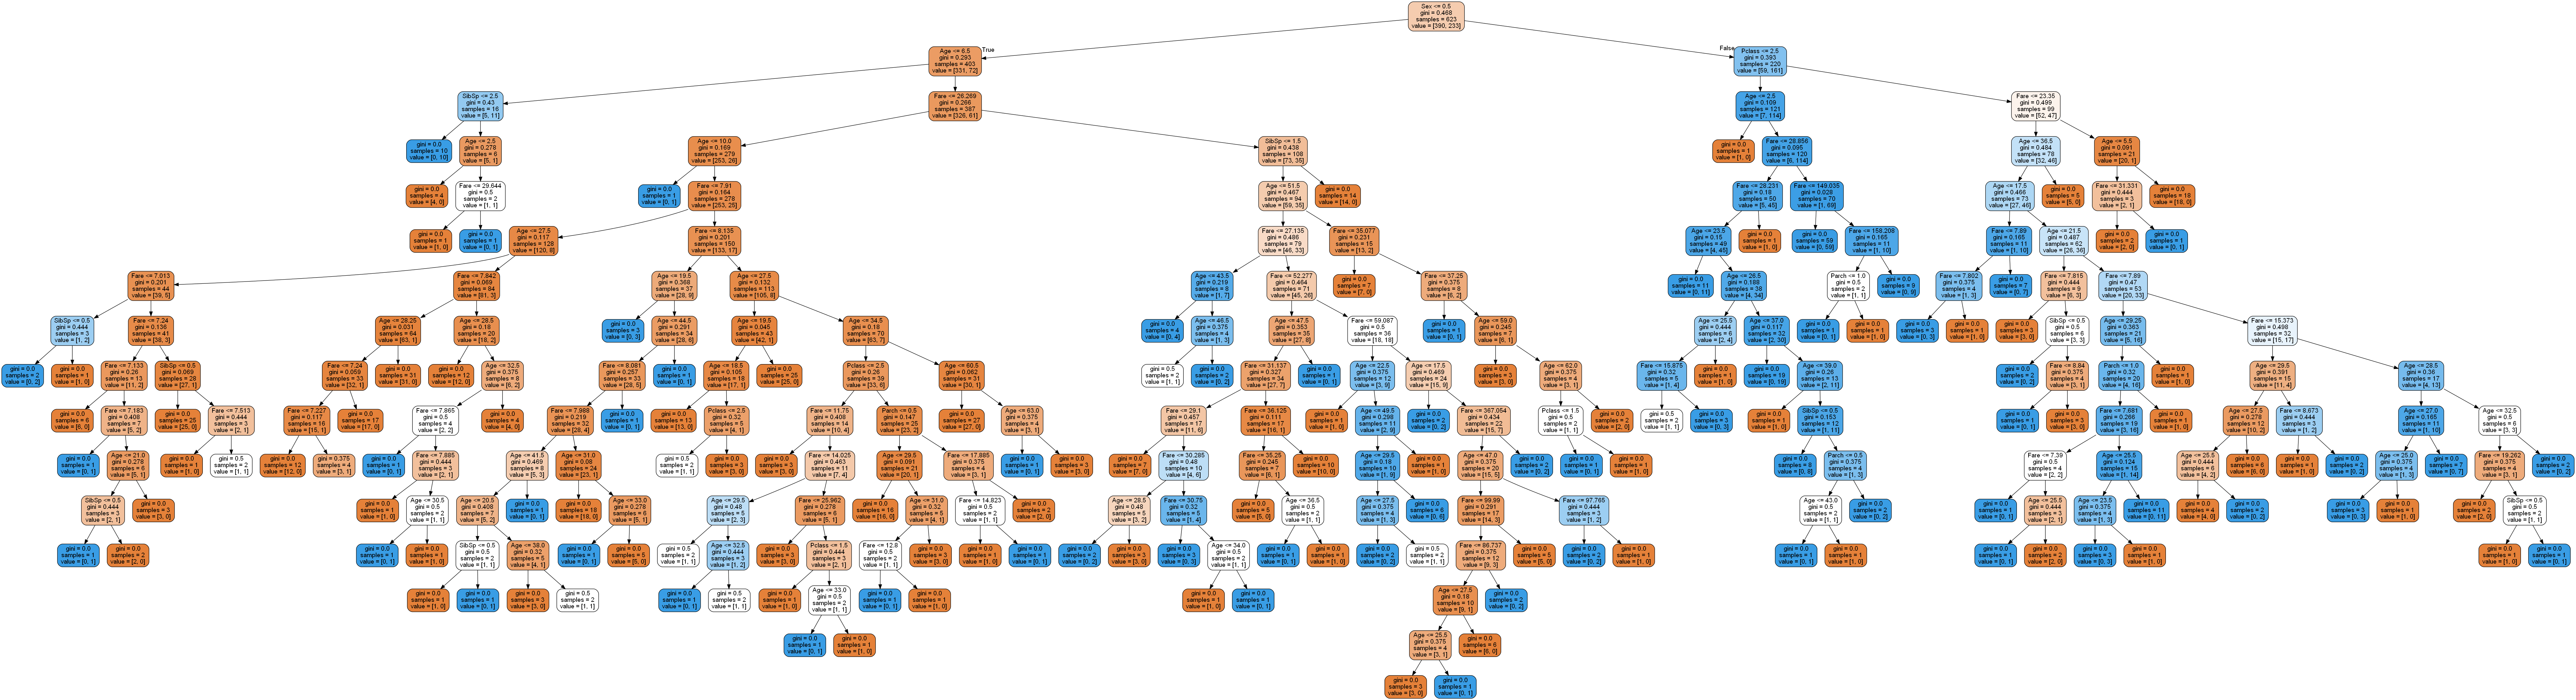

In [40]:
# Create a dot file while stores the tree structure
dot_data = export_graphviz(clf,feature_names = feature_name, rounded=True, filled=True)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png("TitanicDTree.png")

# Display graph
Image(graph.create_png())

In [41]:
clf.score(x_train,y_train)

0.985553772070626

### Fitting test data to the model

In [42]:
clf.score(x_test,y_test)

0.7723880597014925

### Hyperparameter tuning


In [44]:
# we are tuning three hyperparameters right now, we are passing the different values for both parameters
grid_param = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : range(2,17,1),
    'min_samples_leaf' : range(1,10,1),
    'min_samples_split': range(2,10,1),
    'splitter' : ['best', 'random']
    
}

In [45]:
grid_search = GridSearchCV(estimator=clf,
                     param_grid=grid_param,
                     cv=5,
                    n_jobs =-1)

In [46]:
grid_search.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(2, 17),
                         'min_samples_leaf': range(1, 10),
                         'min_samples_split': range(2, 10),
                         'splitter': ['best', 'random']})

In [47]:
best_parameters = grid_search.best_params_
print(best_parameters)

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'best'}


In [48]:
grid_search.best_score_

0.8379096774193548

In [49]:
clf = DecisionTreeClassifier(criterion = 'entropy', max_depth =5, min_samples_leaf= 1, min_samples_split= 4, splitter ='best')
clf.fit(x_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=4)

In [50]:
clf.score(x_test,y_test)

0.8134328358208955

In [51]:
res1 = clf.predict([[1,0,38.0,1,0,71.2833]])
res2 = clf.predict([[3,1,35.0,0,0,8.0500]])
res2[0]

1

GridSearchCv has improved my score.

##### With Hyper parameter tuning, I am able to achieve accuracy of 81.343% (test)

Let's visualize the new Decision Tree model built


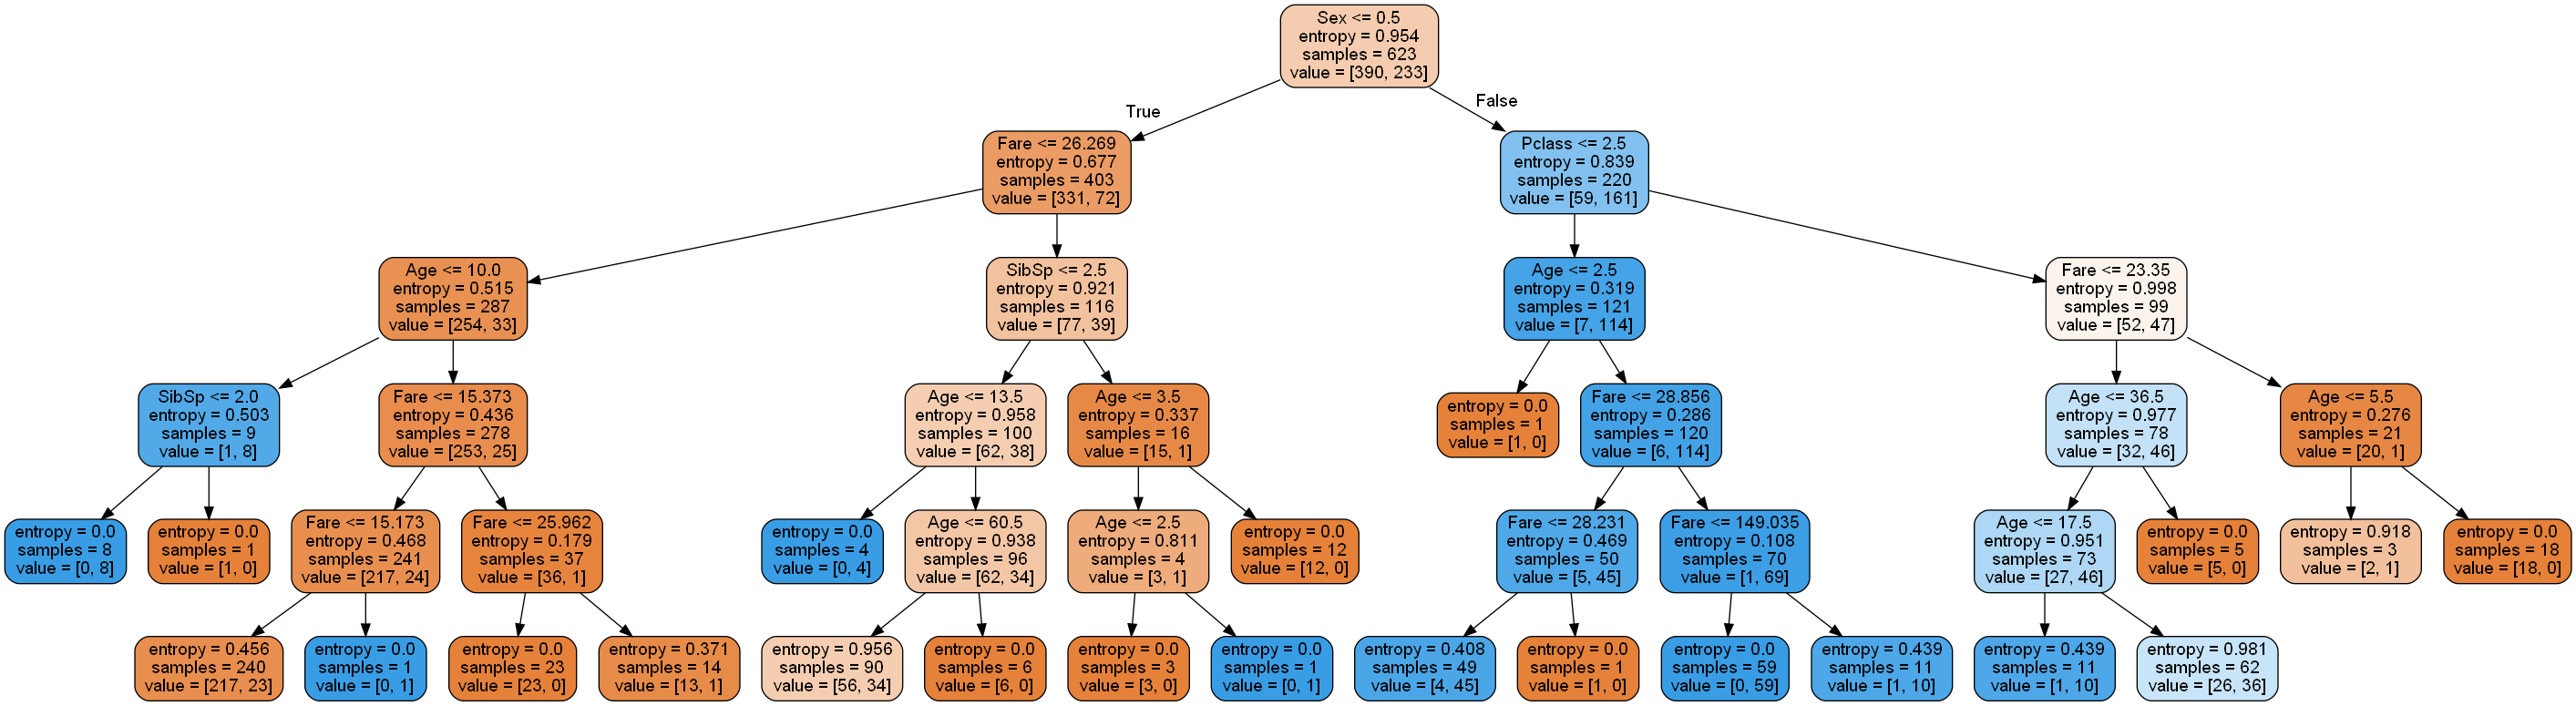

In [52]:
# Create a dot file while stores the tree structure
dot_data = export_graphviz(clf,feature_names = feature_name, rounded=True, filled=True)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png("TitanicDTreeFinal.png")

# Display graph
Image(graph.create_png())

In [39]:
# let's save the model
import pickle

with open('E://Learn/Data Science/Decision Tree impl on Titanic data'+ '/DecisionTreeModel.sav', 'wb') as f:
    pickle.dump(clf,f)


### Prediction based on new model


In [53]:
y_test_pred = clf.predict(x_test)

In [54]:
y_test_pred

array([1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 0], dtype=int64)

##### Let's calculate some of the classification evaluation metrics

In [56]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score

In [58]:
accuracy  = accuracy_score(y_test,y_test_pred)
accuracy

0.8134328358208955

In [59]:
confusion_mat = confusion_matrix(y_test,y_test_pred)
confusion_mat

array([[142,  17],
       [ 33,  76]], dtype=int64)

In [60]:
true_positive = confusion_mat[0][0]
false_positive = confusion_mat[0][1]
false_negative = confusion_mat[1][0]
true_negative = confusion_mat[1][1]

In [62]:
Accuracy = (true_positive + true_negative) /(true_positive + false_positive + false_negative + true_negative)
Accuracy

0.8134328358208955

In [63]:
Precision = true_positive / (true_positive + false_positive)
Precision

0.8930817610062893

In [64]:
Recall = true_positive / (true_positive + false_negative)
Recall

0.8114285714285714

In [65]:
F1_Score = (2 * (Precision * Recall))/ (Precision + Recall)
F1_Score

0.8502994011976048

In [66]:
Specificity = true_negative / (true_negative + false_positive)
Specificity

0.8172043010752689

In [67]:
False_positive_rate = 1-Specificity
False_positive_rate

0.18279569892473113

In [68]:
auc = roc_auc_score(y_test,y_test_pred)
auc

0.7951647337141539